<a href="https://colab.research.google.com/github/sidharth178/House-Prices-Advanced-Regression-Techniques/blob/master/House_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>**===========House Prices - Advanced Regression Techniques============**</center>

# **Introduction**
### **Objective:** 
The objective of the project is to perform advance regression techniques to predict the house price in Boston.
### **Data Description:**
- train.csv - the training set
- test.csv - the test set
- data_description.txt - full description of each column, originally prepared by Dean De Cock but lightly edited to match the column names used here
- sample_submission.csv - a benchmark submission from a linear regression on year and month of sale, lot square footage, and number of bedrooms

### **Table of Content:**
1. Fetch Dataset
2. Install & Import Libraries
3. Load Datasets
4. Exploratory Data Analysis
5. Feature Engineering
6. Model Development
7. Find Prediction





# **1. Fetch datasets from kaggle**

In [7]:
# Step-1: create .kaggle directory
!mkdir ~/.kaggle

# Step-2: create a API token in your kaggle account.Upload this token("kaggle.json") on any folder here.move this file into ~/.kaggle.
# Below code is for moving ".json" file
!mv /content/sample_data/kaggle.json ~/.kaggle/kaggle.json

# Step-3: give authorization to KaggleApi
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

!chmod 600 ~/.kaggle/kaggle.json

# Step-4: Download datasets from kaggle using API
!kaggle competitions download -c house-prices-advanced-regression-techniques

mkdir: cannot create directory ‘/root/.kaggle’: File exists
  0% 0.00/441k [00:00<?, ?B/s]
100% 441k/441k [00:00<00:00, 30.6MB/s]
  0% 0.00/13.1k [00:00<?, ?B/s]
100% 13.1k/13.1k [00:00<00:00, 13.9MB/s]
  0% 0.00/450k [00:00<?, ?B/s]
100% 450k/450k [00:00<00:00, 14.6MB/s]
  0% 0.00/31.2k [00:00<?, ?B/s]
100% 31.2k/31.2k [00:00<00:00, 55.2MB/s]


# **2. Install & Import Libraries**

In [8]:
# use to visualize missing value
pip install missingno

In [9]:
# use for hyper parameter tuning
pip install optuna

In [10]:
# use to choose best algorithms for our dataset 
!pip install lazypredict==0.2.7

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
## Display all the columns of the dataframe
pd.pandas.set_option('display.max_columns',None)

from scipy import stats
from scipy.stats import norm, skew # for some statistics
import warnings # to ignore warning
from sklearn.preprocessing import RobustScaler, PowerTransformer, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

import lazypredict
from lazypredict.Supervised import LazyRegressor
import optuna
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LassoCV, RidgeCV

from sklearn.ensemble import StackingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgb
import joblib

print("Library Imported!!")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


Library Imported!!


# **3. Load Datasets**

In [12]:
# load train and test dataset
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")

# combined train and test datasets
combined_df = pd.concat([train_df,test_df],axis=0)

# **4. Exploratory Data Analysis**
### 4.1. Train Data Exploration

For both train and test dataset, We'll explore following things

- First 5 rows
- Data shape
- Data information
- Data types
- Null value

### 4.1.1. First 5 records

In [13]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.00,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.00,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.00,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.00,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.00,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.00,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.00,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.00,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.00,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.00,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.00,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.00,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.00,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.00,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.00,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### 4.1.2. Data Shape - Train Data

In [14]:
train_df.shape

(1460, 81)

### 4.1.3. Data Information - Train Data

In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### 4.1.4. Data Type - Train Data

In [16]:
train_dtype = train_df.dtypes
train_dtype.value_counts()

object     43
int64      35
float64     3
dtype: int64

### 4.1.5. Null Value - Train Data

In [17]:
train_df.isnull().sum().sort_values(ascending = False).head(20)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageCond        81
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
Utilities          0
dtype: int64

### 4.1.6. Visualize missing value using **Misingno** - Train Data

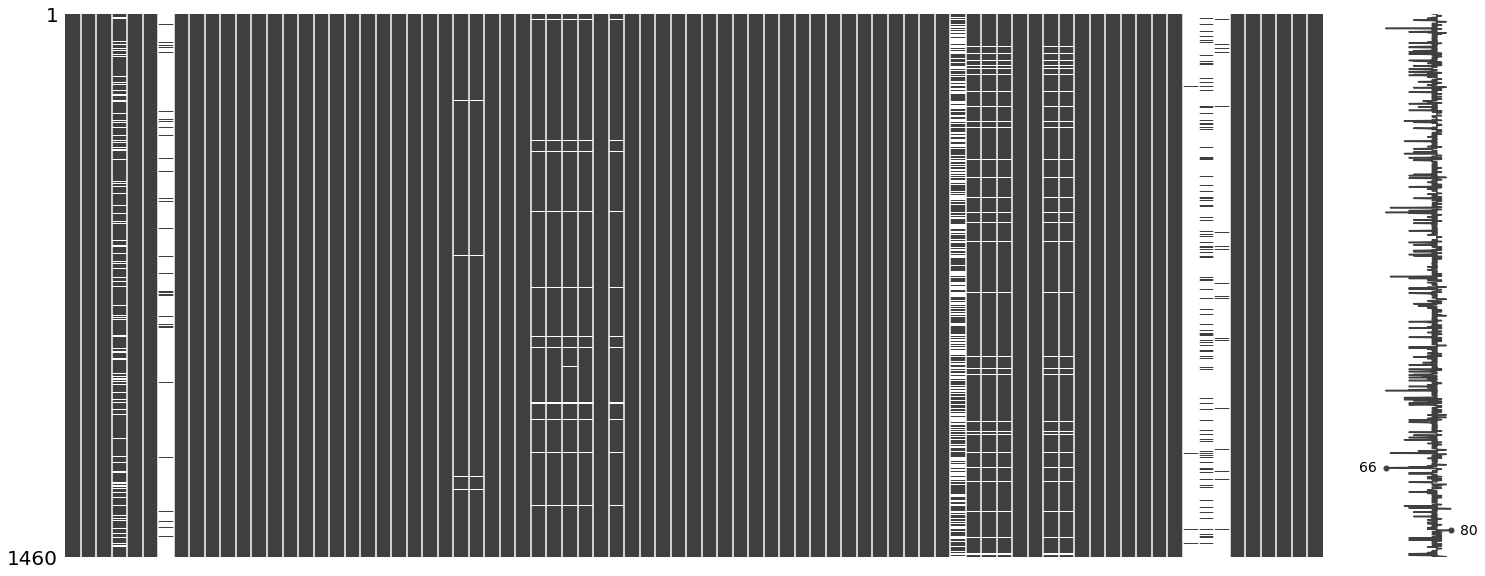

In [18]:
msno.matrix(train_df)

- The missingno correlation heatmap measures nullity correlation: how strongly the presence or absence of one variable affects the presence of another.

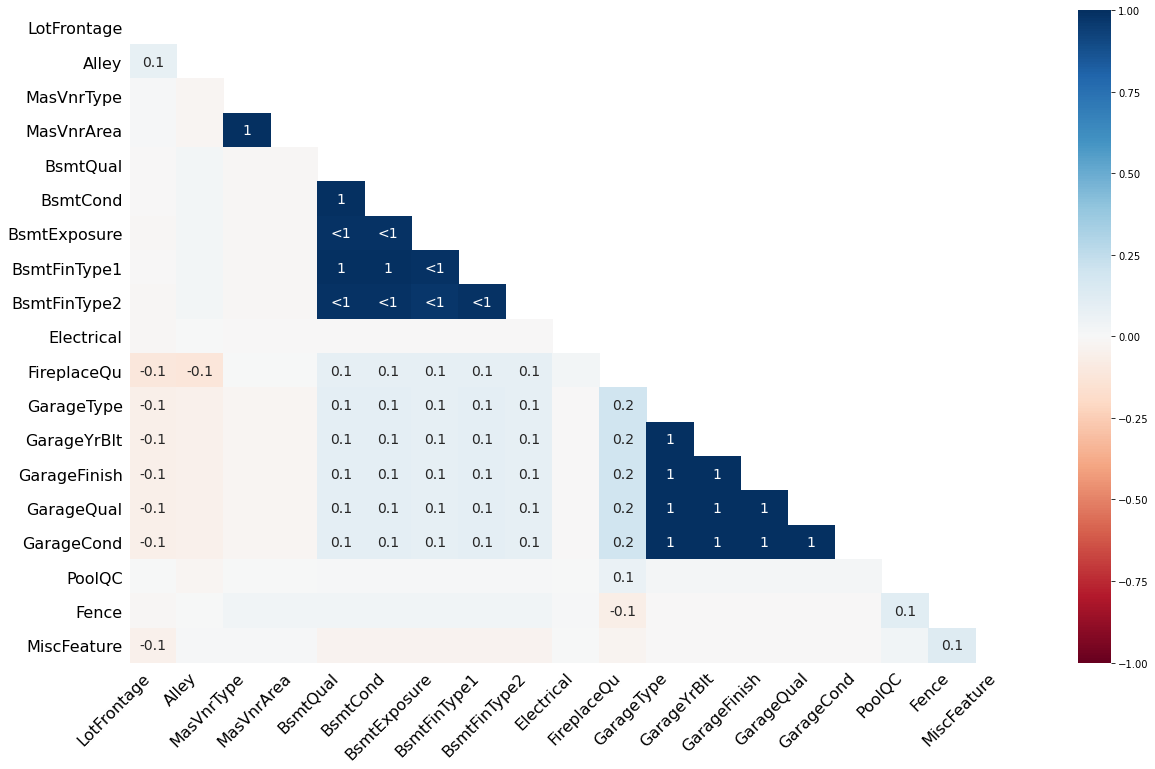

In [19]:
msno.heatmap(train_df)

### 4.2. Test Data Exploration

### 4.2.1. First 5 rows - Test Data

In [20]:
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.00,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.00,TA,TA,CBlock,TA,TA,No,Rec,468.00,LwQ,144.00,270.00,882.00,GasA,TA,Y,SBrkr,896,0,0,896,0.00,0.00,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.00,Unf,1.00,730.00,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.00,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.00,TA,TA,CBlock,TA,TA,No,ALQ,923.00,Unf,0.00,406.00,1329.00,GasA,TA,Y,SBrkr,1329,0,0,1329,0.00,0.00,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.00,Unf,1.00,312.00,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.00,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.00,TA,TA,PConc,Gd,TA,No,GLQ,791.00,Unf,0.00,137.00,928.00,GasA,Gd,Y,SBrkr,928,701,0,1629,0.00,0.00,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.00,Fin,2.00,482.00,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.00,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.00,TA,TA,PConc,TA,TA,No,GLQ,602.00,Unf,0.00,324.00,926.00,GasA,Ex,Y,SBrkr,926,678,0,1604,0.00,0.00,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.00,Fin,2.00,470.00,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.00,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.00,Gd,TA,PConc,Gd,TA,No,ALQ,263.00,Unf,0.00,1017.00,1280.00,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.00,0.00,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.00,RFn,2.00,506.00,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


### 4.2.2. Data Type - Test Data

In [21]:
test_dtype = test_df.dtypes
test_dtype.value_counts()

object     43
int64      26
float64    11
dtype: int64

### 4.2.3. Data Information - Test Data

In [22]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

### 4.2.4. Data Shape - Test Data

In [23]:
test_df.shape

(1459, 80)

### 4.2.5. Null Data - Test Data

In [24]:
test_df.isnull().sum().sort_values(ascending = False).head(20)

PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
FireplaceQu      730
LotFrontage      227
GarageCond        78
GarageQual        78
GarageYrBlt       78
GarageFinish      78
GarageType        76
BsmtCond          45
BsmtQual          44
BsmtExposure      44
BsmtFinType1      42
BsmtFinType2      42
MasVnrType        16
MasVnrArea        15
MSZoning           4
BsmtHalfBath       2
dtype: int64

### 4.2.6. Visualize missing value using **Misingno** - Test Data

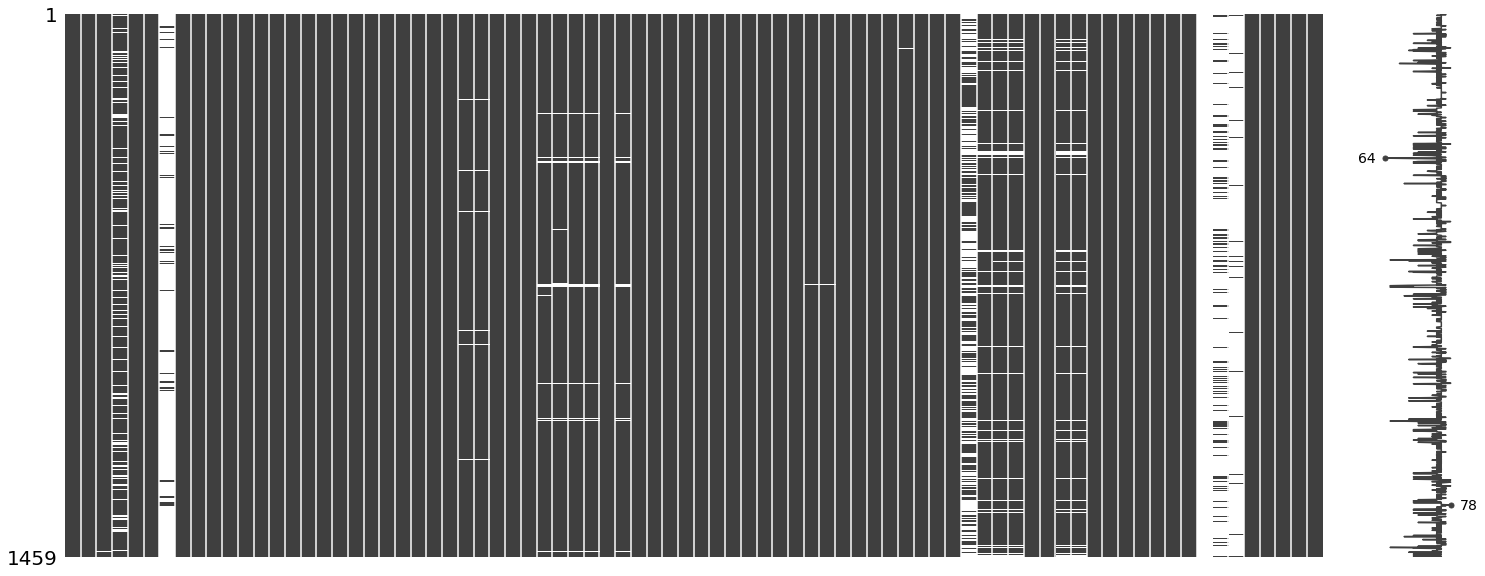

In [25]:
msno.matrix(test_df)

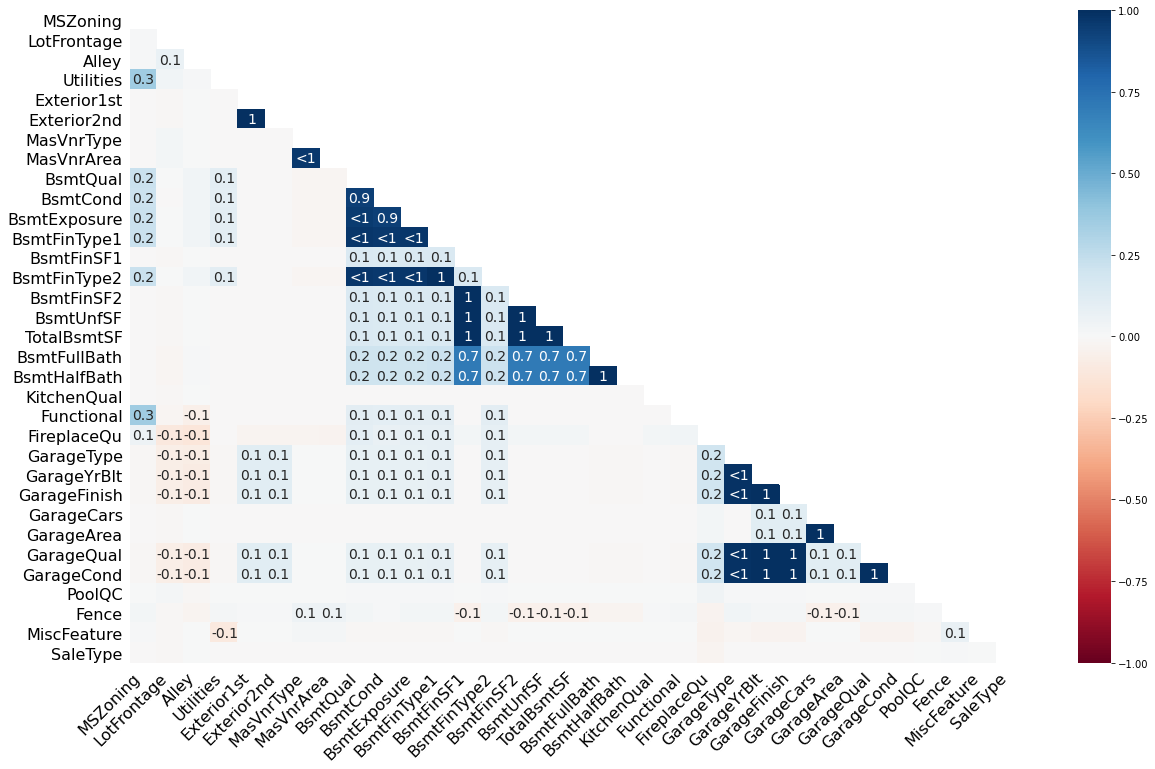

In [26]:
msno.heatmap(test_df)

### 4.3. Train & Test Data Comparison

Here we'll compare below things between train and test dataset.
- Data Type
- Null values
- Data Distribution

### 4.3.1. Data Type Comparison

In [27]:
# as 'SalePrice' Column is not available in test dataset. So we'll delete it.
trn_dtype = train_dtype.drop('SalePrice')
trn_dtype.compare(test_dtype)

,self,other
BsmtFinSF1,int64,float64
BsmtFinSF2,int64,float64
BsmtUnfSF,int64,float64
TotalBsmtSF,int64,float64
BsmtFullBath,int64,float64
BsmtHalfBath,int64,float64
GarageCars,int64,float64
GarageArea,int64,float64


In [28]:
test_df["TotalBsmtSF"].head()

0    882.00
1   1329.00
2    928.00
3    926.00
4   1280.00
Name: TotalBsmtSF, dtype: float64

- Here We can see some columns have inconsistent data types i.e int64 & float64. It's not a problem.

### 4.3.2. Null Value Comparison

In [29]:
null_train = train_df.isnull().sum()
null_test = test_df.isnull().sum()
null_train = null_train.drop('SalePrice')
null_comp_df = null_train.compare(null_test).sort_values(['self'],ascending = [False])
null_comp_df  

,self,other
PoolQC,1453.00,1456.00
MiscFeature,1406.00,1408.00
Alley,1369.00,1352.00
Fence,1179.00,1169.00
FireplaceQu,690.00,730.00
LotFrontage,259.00,227.00
GarageType,81.00,76.00
GarageCond,81.00,78.00
GarageYrBlt,81.00,78.00
GarageFinish,81.00,78.00


- Here we can see that columns like **"Alley", "Fence", "LotFrontage", "FireplaceQu"**  have maximum number of null value. So we will consider to drop these columns.

### 4.3.3. Distribution Comparison

In [30]:
numerical_features = [col for col in train_df.columns if train_df[col].dtypes != 'O']
discrete_features = [col for col in numerical_features if len(train_df[col].unique()) < 25 and col not in ['Id']]
continuous_features = [feature for feature in numerical_features if feature not in discrete_features+['Id']]
categorical_features = [col for col in train_df.columns if train_df[col].dtype == 'O']

print("Total Number of Numerical Columns : ",len(numerical_features))
print("Number of discrete features : ",len(discrete_features))
print("No of continuous features are : ", len(continuous_features))
print("Number of discrete features : ",len(categorical_features))

Total Number of Numerical Columns :  38
Number of discrete features :  18
No of continuous features are :  19
Number of discrete features :  43


In [31]:
combined_df["Label"] = "test"
combined_df["Label"][:1460] = "train"

### 4.3.3.1. Distribution Comparison - Discrete

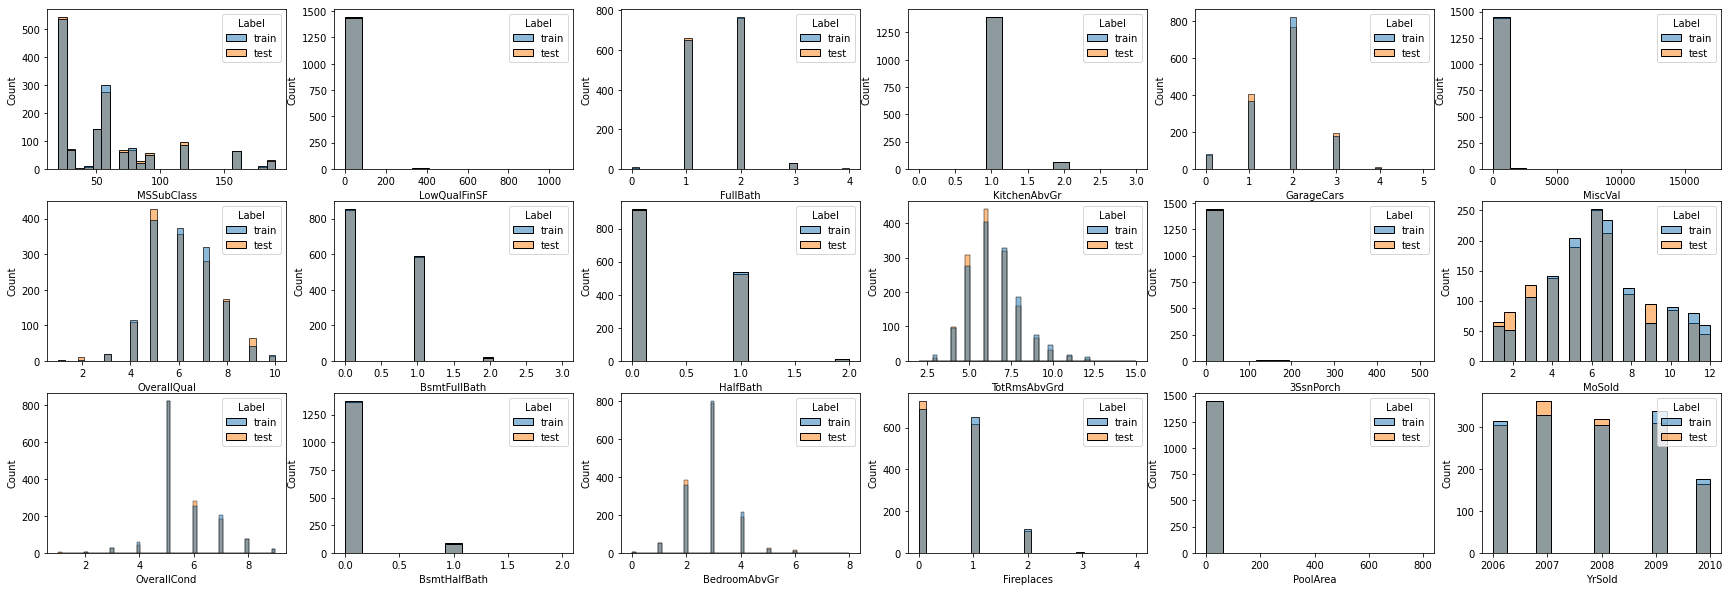

In [32]:
f, axes = plt.subplots(3,6 , figsize=(30, 10), sharex=False)
for i, feature in enumerate(discrete_features):
    sns.histplot(data=combined_df, x = feature, hue="Label",ax=axes[i%3, i//3]) 

Above distribution shows that:
- Some features can be reclassified as 'Categorical', such as **'MSSubClass'**.
- Some features are dominated by 0/null **(eg:PoolArea, LowQualFinSF, 3SsnPorch, MiscVal )**, thus we can consider to drop.

### 4.3.3.2. Distribution Comparison - Continuous

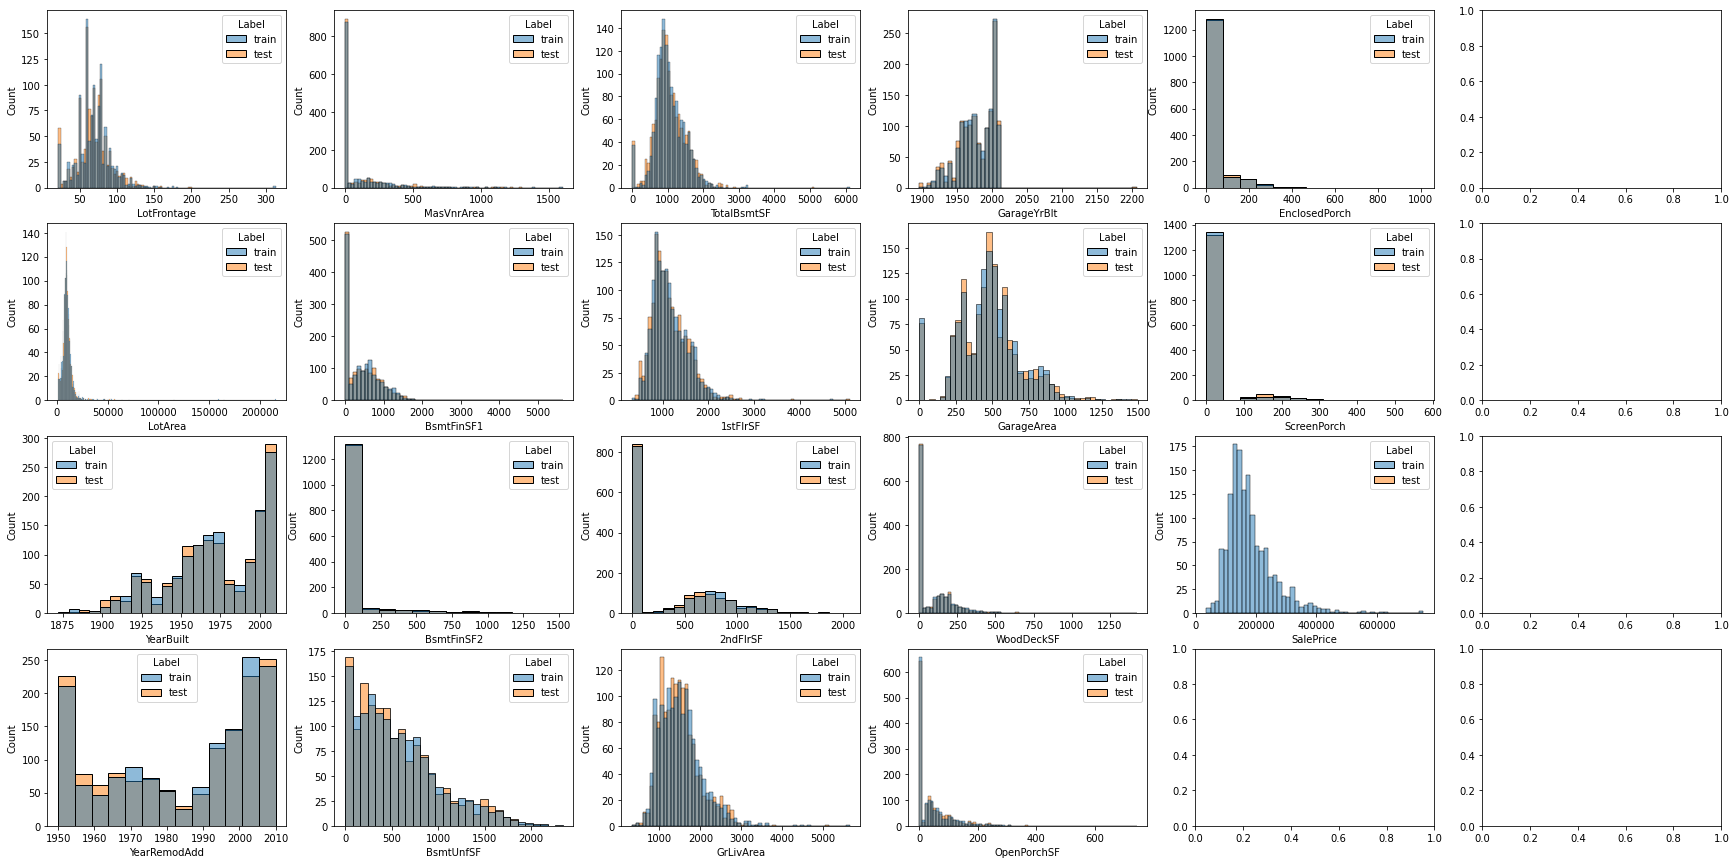

In [33]:
f, axes = plt.subplots(4,6 , figsize=(30, 15), sharex=False)
for i, feature in enumerate(continuous_features):
    sns.histplot(data=combined_df, x = feature, hue="Label",ax=axes[i%4, i//4]) 

Above distribution shows that:
- The distribution of train and test data are similar for most continous features.

### 4.3.3.3. Linearity Check
Here we'll see the linearity between all features and the target variable.

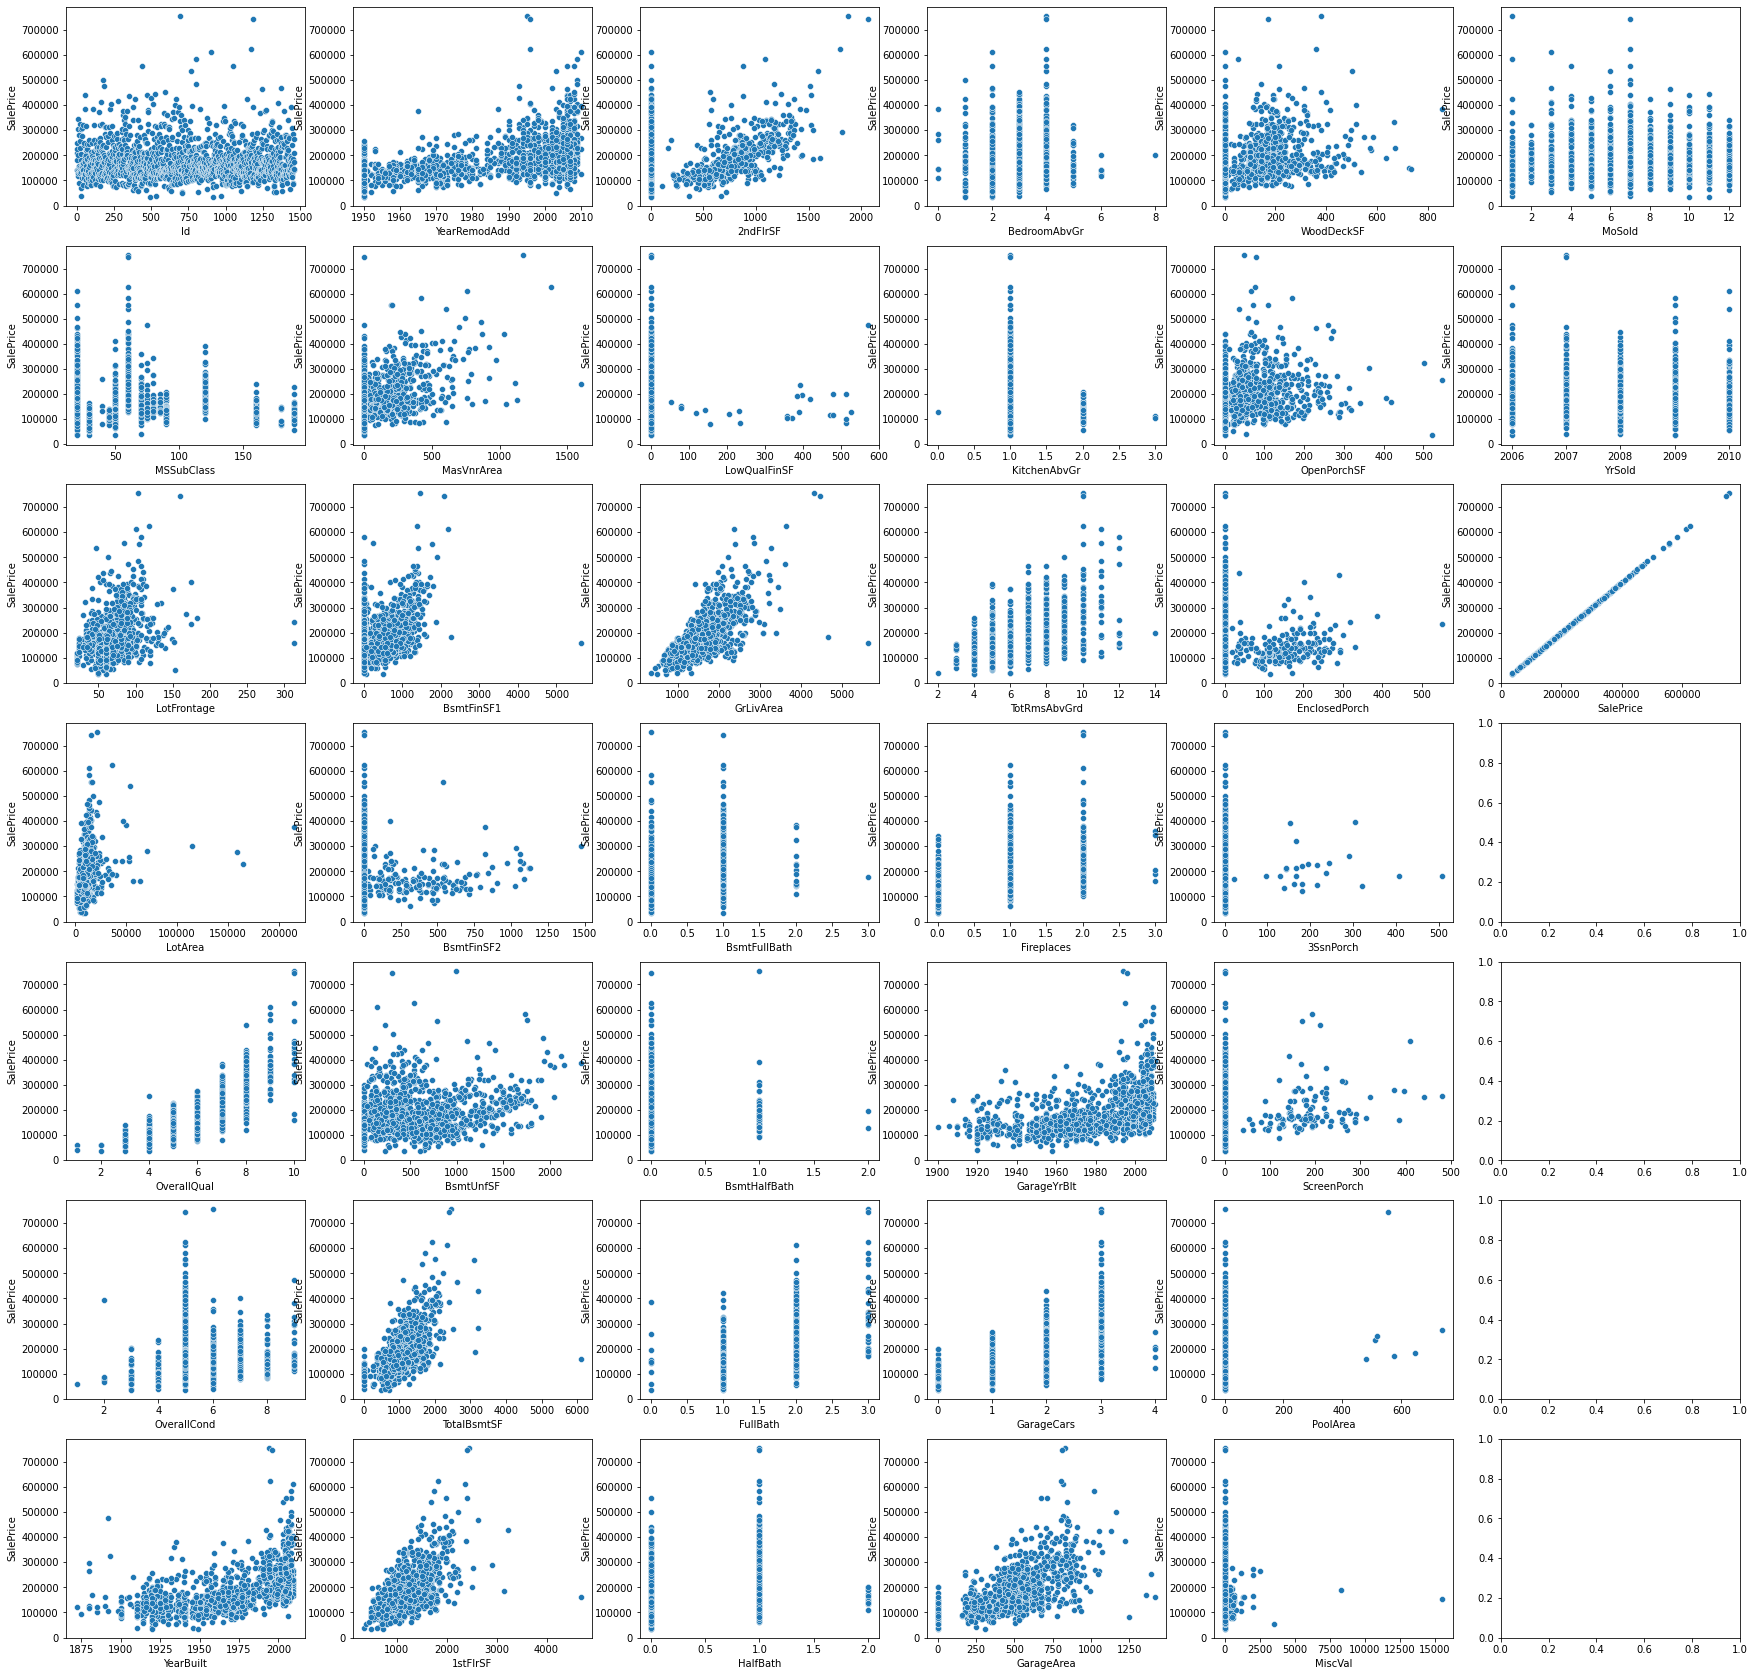

In [34]:
f, axes = plt.subplots(7,6 , figsize=(30, 30), sharex=False)
for i, feature in enumerate(numerical_features):
    sns.scatterplot(data=combined_df, x = feature, y= "SalePrice",ax=axes[i%7, i//7])

We notice that some features are not linear towards target feature.

- 'SalePrice' VS.'BsmtUnfSF',
- 'SalePrice' VS.'TotalBsmtSF',
- 'SalePrice' VS.'GarageArea',
- 'SalePrice' VS.'LotArea',
- 'SalePrice' VS.'LotFrontage',
- 'SalePrice' VS.'GrLivArea',
- 'SalePrice' VS.'1stFlrSF',



### 4.3.3.4. Distribution Comparison - Categorical 

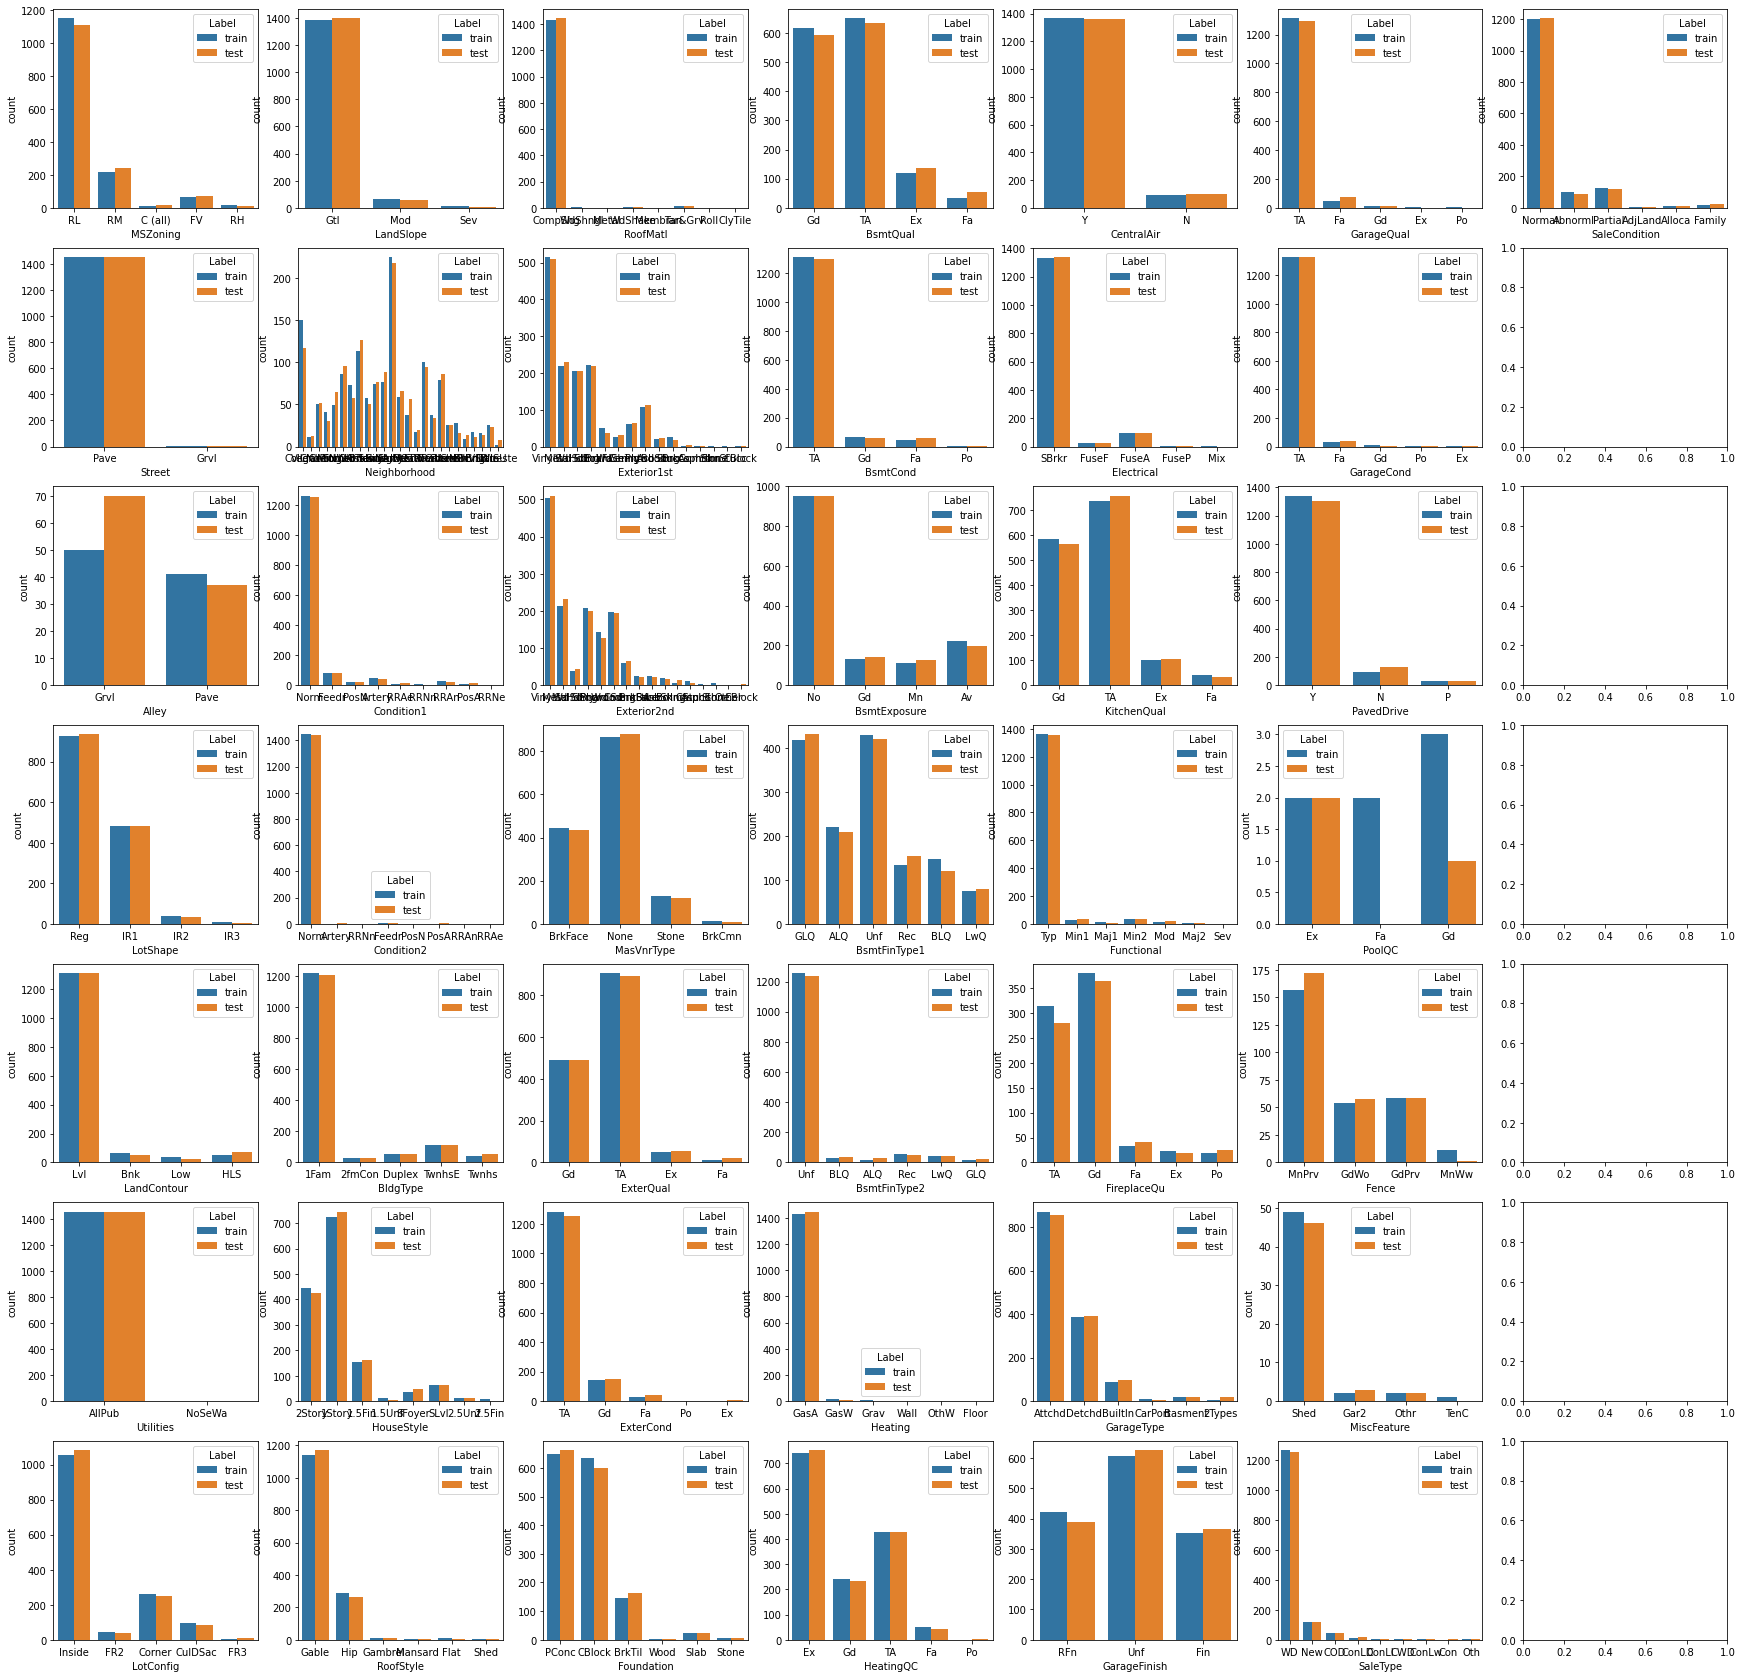

In [35]:
f, axes = plt.subplots(7,7 , figsize=(30, 30), sharex=False)
for i, feature in enumerate(categorical_features):
    sns.countplot(data = combined_df, x = feature, hue="Label",ax=axes[i%7, i//7])

Above distribution shows that:

- The distribution of train and test data are similar for most categorical features.
- Some features have dominant items, we can combine some minor items into a group otherwise we can drop these columns.
- Ex: **'RoofMatl','Street','Condition2','Utilities','Heating'** (These columns should be dropped)
- Ex: 'Fa' & 'Po' in 'HeatingQC', 'FireplaceQu', 'GarageQual' and 'GarageCond'

Now let's conform that the items we want to combine has similar prices(SalePrices value).


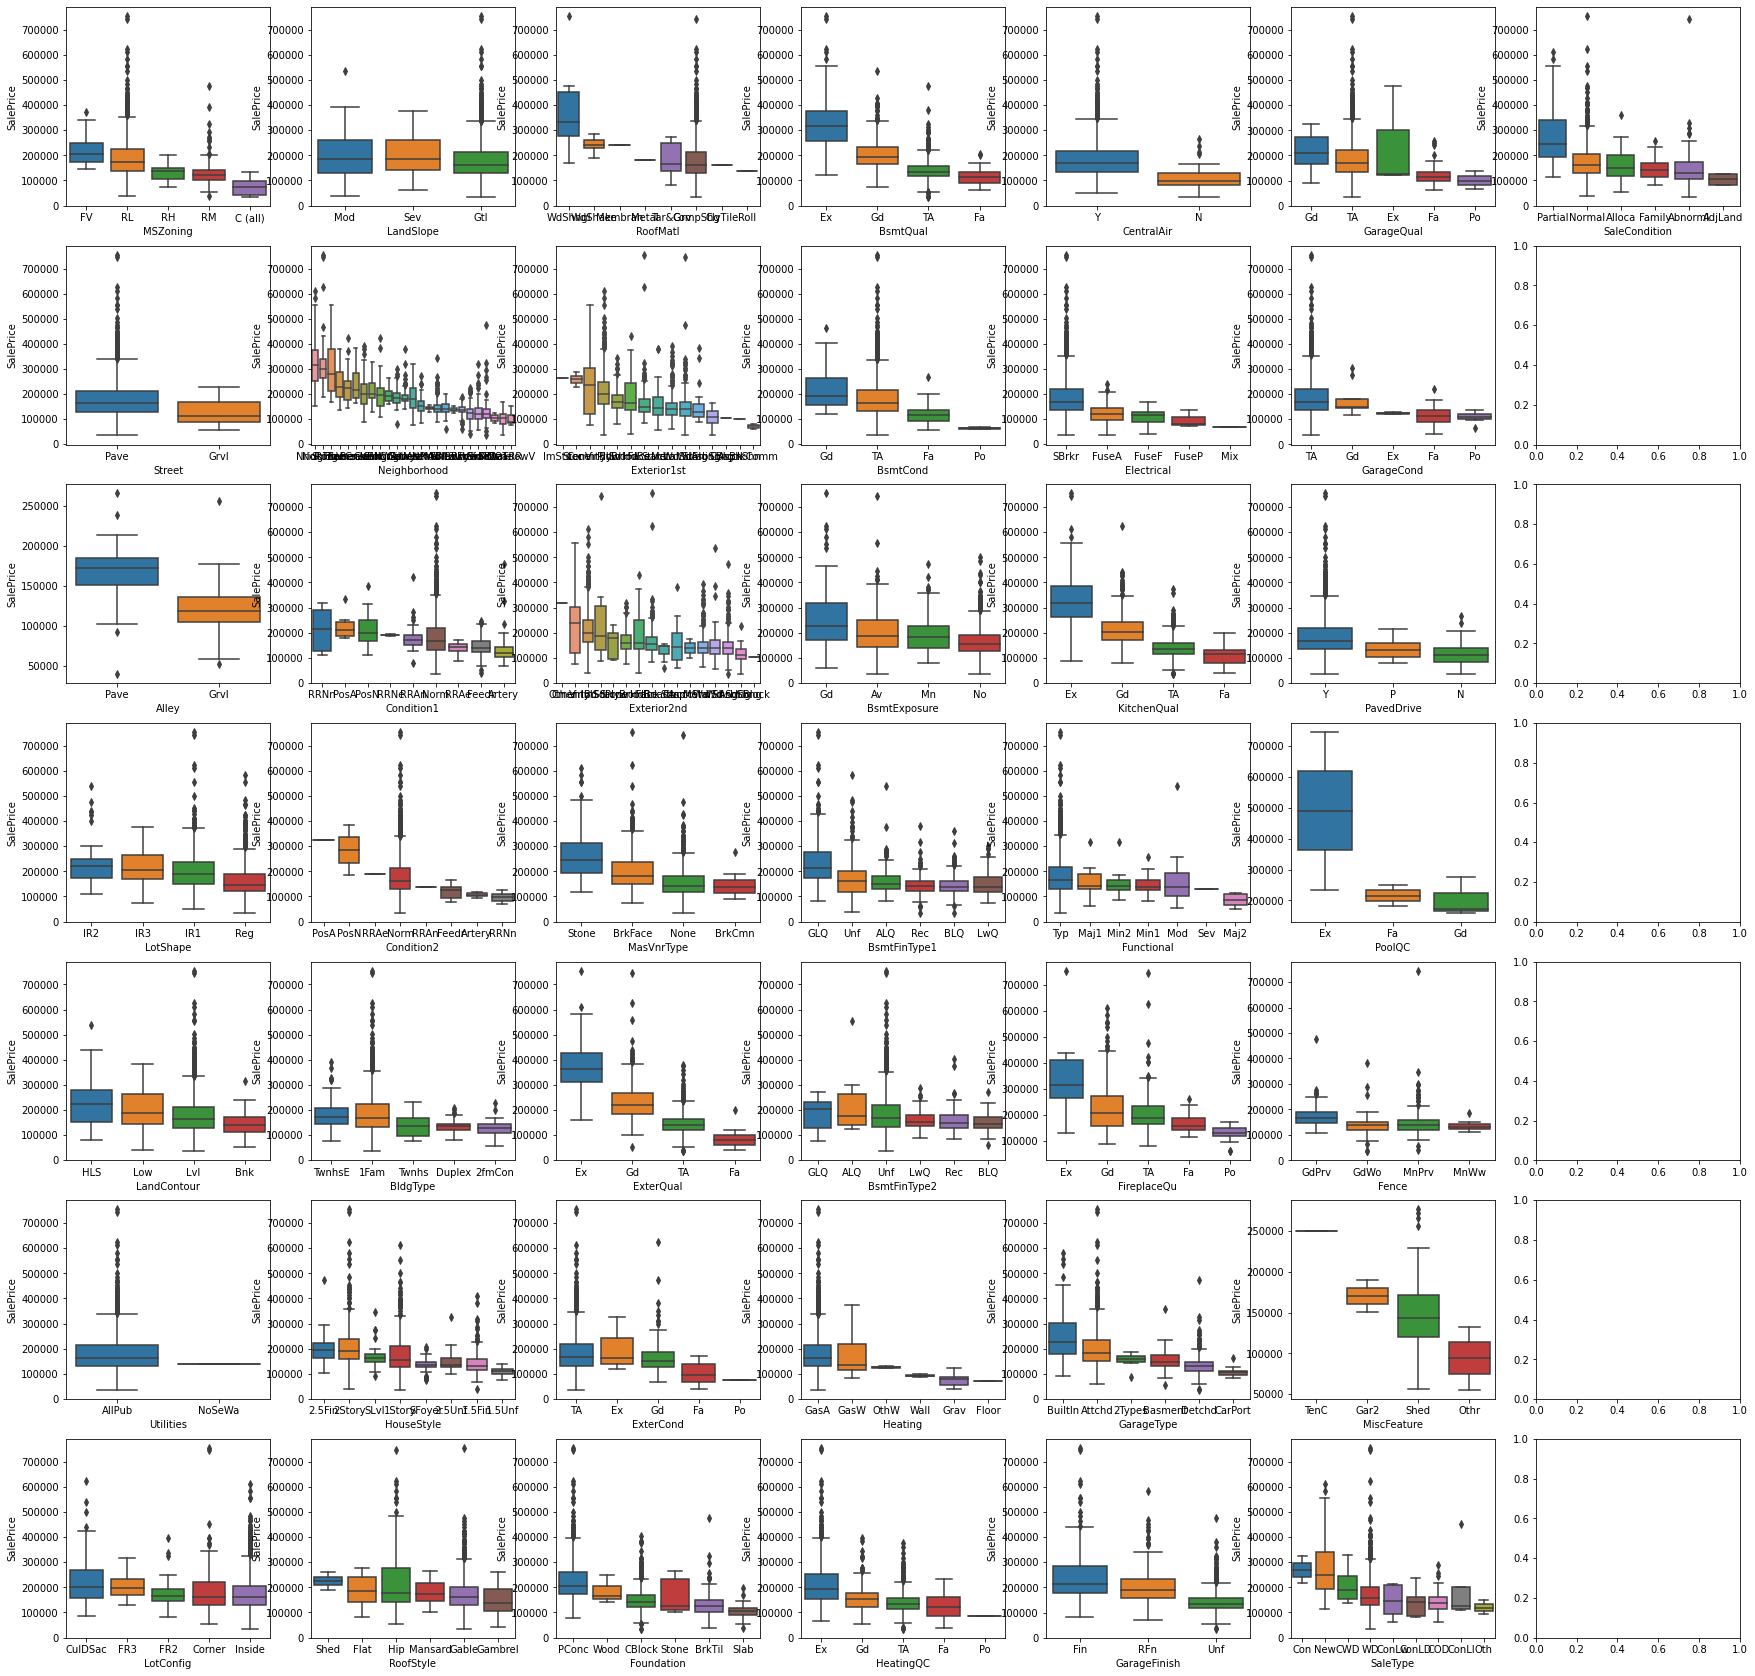

In [36]:
f, axes = plt.subplots(7,7 , figsize=(30, 30), sharex=False)
for i, feature in enumerate(categorical_features):
    sort_list = sorted(combined_df.groupby(feature)['SalePrice'].median().items(), key= lambda x:x[1], reverse = True)
    order_list = [x[0] for x in sort_list ]
    sns.boxplot(data = combined_df, x = feature, y = 'SalePrice', order=order_list, ax=axes[i%7, i//7])
plt.show()

Here, we could see that sale prices for 'Fa' & 'Po' in 'HeatingQC', 'FireplaceQu', 'GarageQual' and 'GarageCond' are similar, so we can combine these items.

### 4.4. Find Suitable value for missing values - Numerical 

### 4.4.1. Fill Mean Value

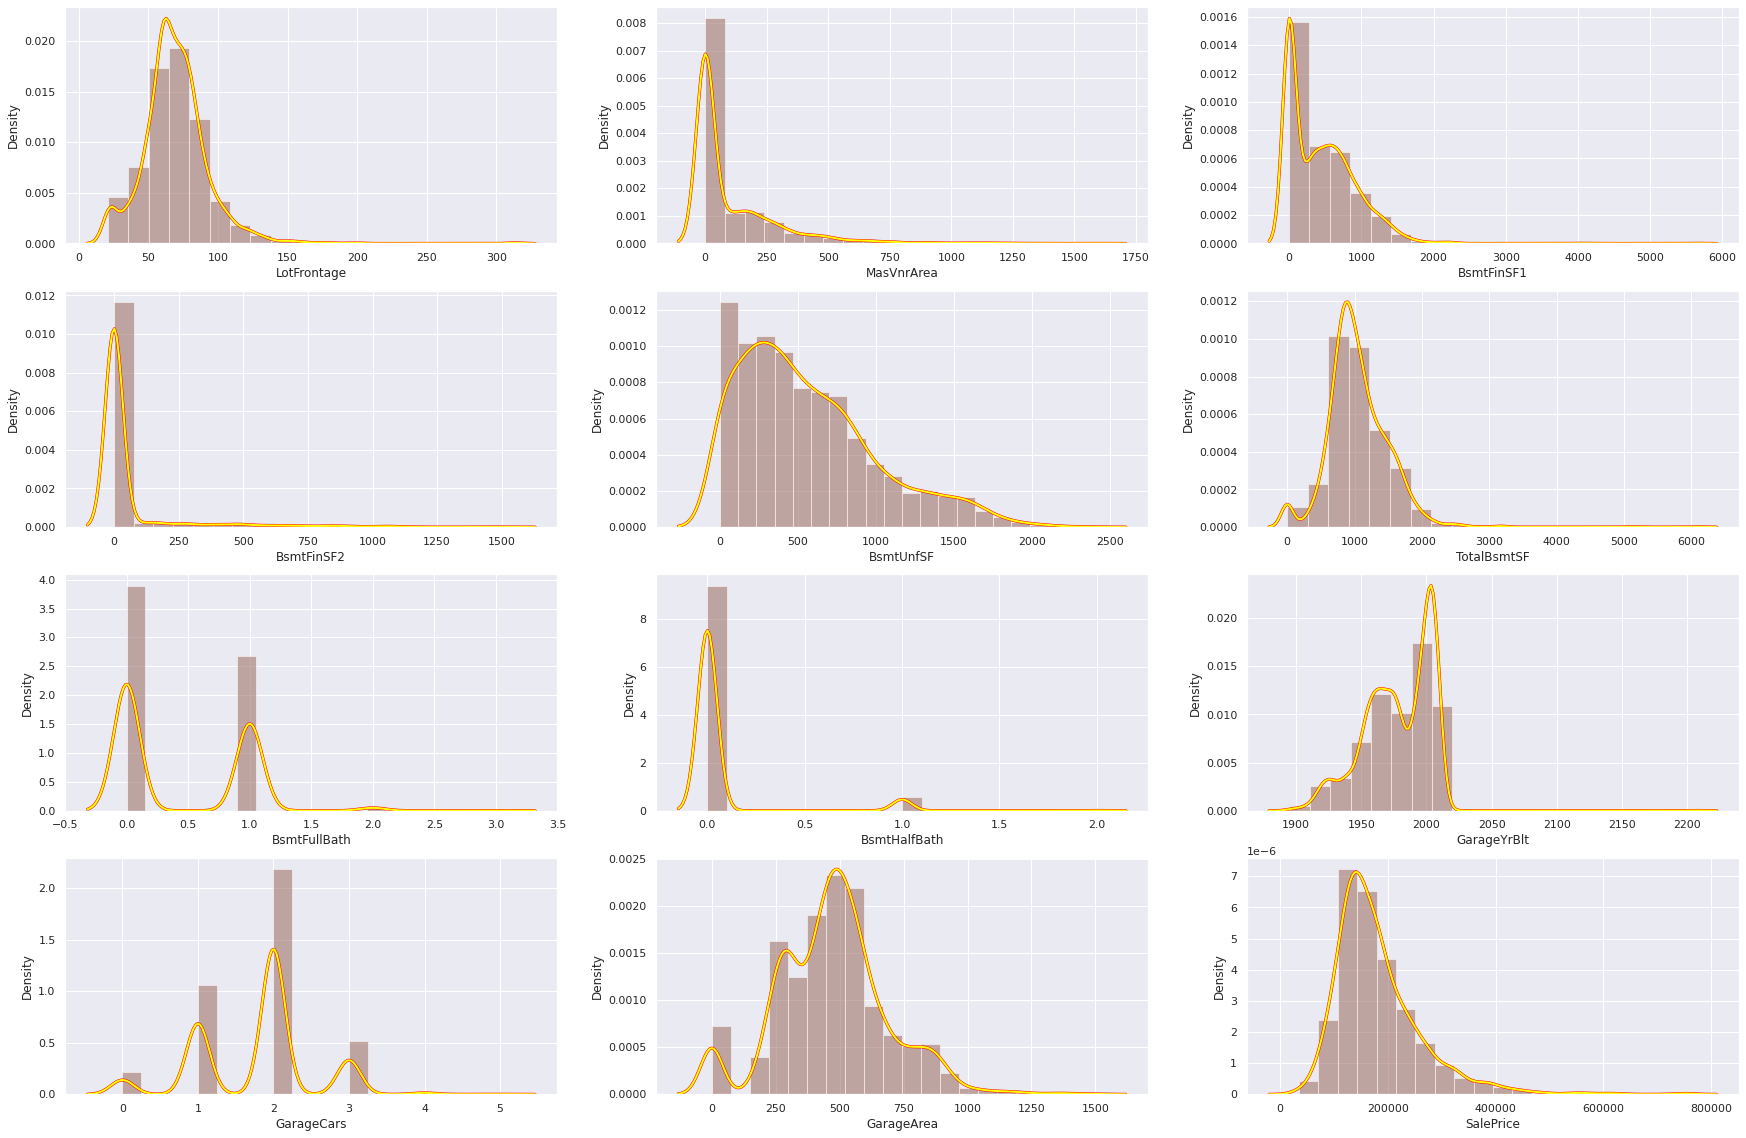

In [37]:
# check the normal distribution of columns having null values by filling with the mean value
null_features_numerical = [col for col in combined_df.columns if combined_df[col].isnull().sum() > 0 and col not in categorical_features]
plt.figure(figsize=(30,20))
sns.set()

warnings.simplefilter("ignore")
for i,var in enumerate(null_features_numerical):
  plt.subplot(4,3,i+1)
  sns.distplot(combined_df[var],bins=20,kde_kws={'linewidth':3,'color':'red'},label="original")
  sns.distplot(combined_df[var],bins=20,kde_kws={'linewidth':2,'color':'yellow'},label="mean")

### 4.4.2. Fill Median Value

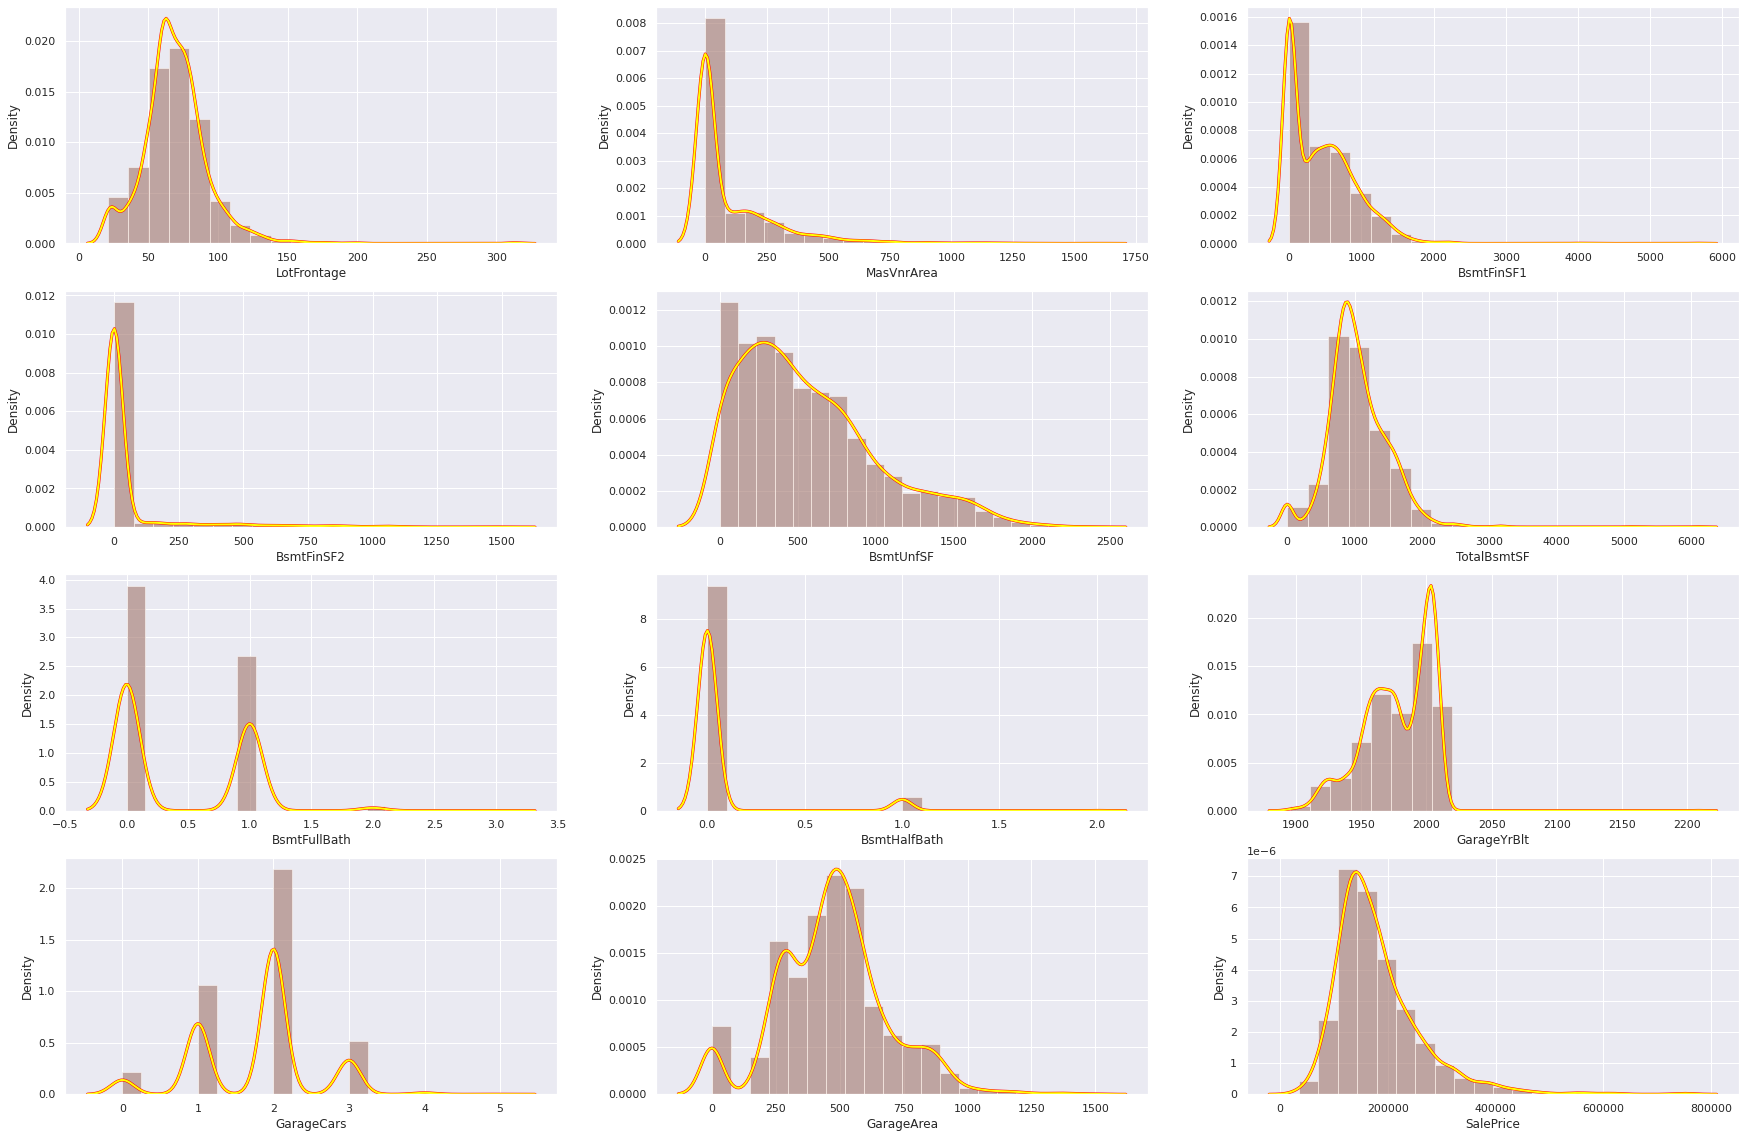

In [38]:
plt.figure(figsize=(30,20))
sns.set()
warnings.simplefilter("ignore")
for i,var in enumerate(null_features_numerical):
  plt.subplot(4,3,i+1)
  sns.distplot(combined_df[var],bins=20,kde_kws={'linewidth':3,'color':'red'},label="original")
  sns.distplot(combined_df[var],bins=20,kde_kws={'linewidth':2,'color':'yellow'},label="median")

- From the above visualization we saw that mean and median value both maintain the same destribution. So we can choose one of them to fill the missing values.

### 4.4.3 Find Suitable value for missing values - Categorical 

In [39]:
# ---------------- do -----------------------

In [40]:
# ---------------- do -----------------------

### 4.5. Temporal Variable Analysis

In [41]:
# variables which contain year information
year_feature = [col for col in combined_df.columns if 'Yr' in col or 'Year' in col]
year_feature

['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']

Check is there any relation betwwn **"Year Sold"** and **"Sales price"**

Text(0.5, 1.0, 'House price vs YearSold')

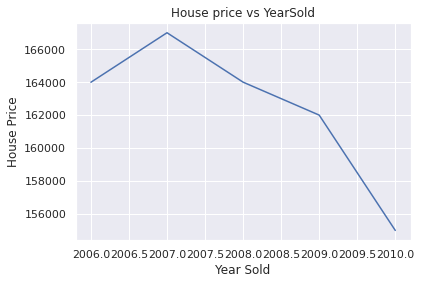

In [42]:
combined_df.groupby('YrSold')['SalePrice'].median().plot()
plt.xlabel('Year Sold')
plt.ylabel('House Price')
plt.title('House price vs YearSold')

Here we'll see how the temporal variables(Year features) affect to House Price

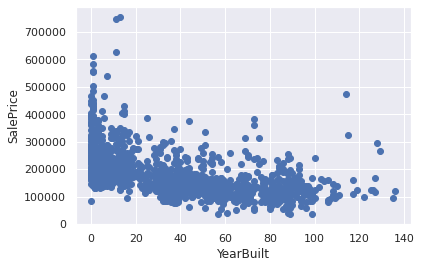

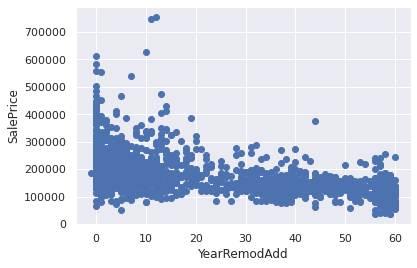

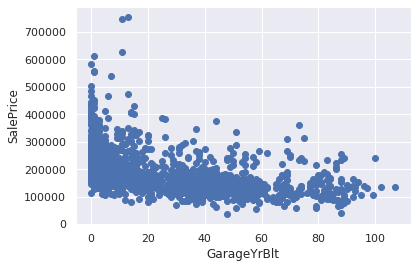

In [43]:
for fet in year_feature:
  if fet != 'YrSold':
    hs = combined_df.copy()
    hs[fet] = hs['YrSold'] - hs[fet]
    plt.scatter(hs[fet],hs['SalePrice'])
    plt.xlabel(fet)
    plt.ylabel('SalePrice')
    plt.show()

### 4.6. Data Correlation

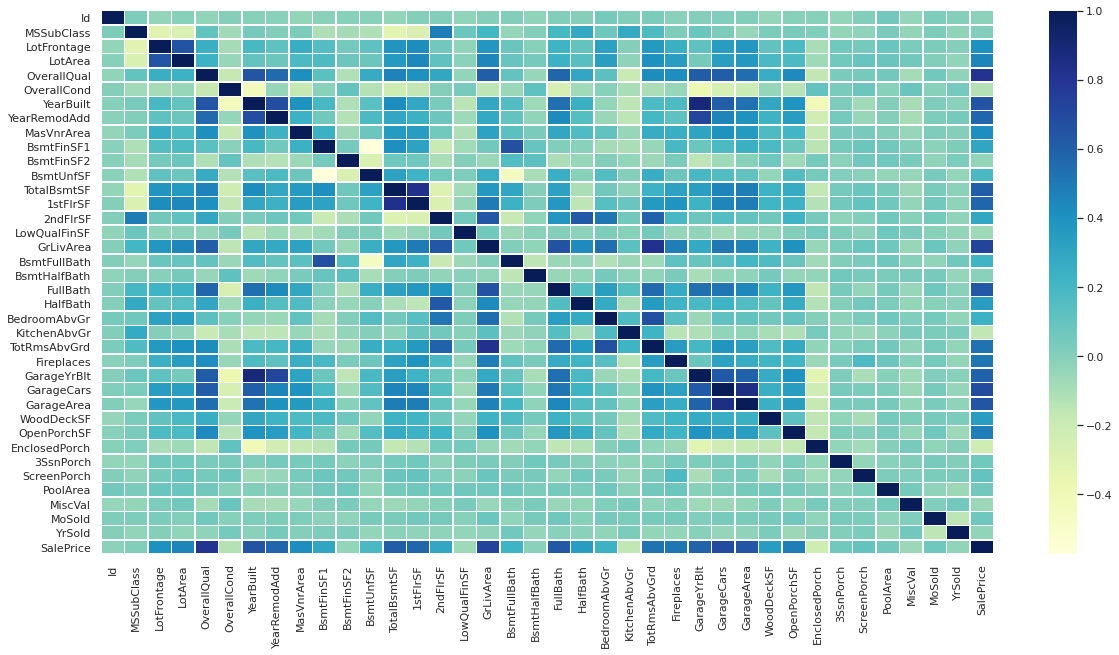

In [44]:
training_corr = train_df.corr(method='spearman')
plt.figure(figsize=(20,10))
sns.heatmap(training_corr, cmap="YlGnBu", linewidths=.5)

#**5. Feature Engineering**

### 5.1. Drop Columns
Here we'll drop columns like
- ID
- Column having more missing value
- Column dominated by 0/null or single value 


In [45]:
drop_columns = ["Id", "Alley", "Fence", "LotFrontage", "FireplaceQu", "PoolArea", "LowQualFinSF", "3SsnPorch", "MiscVal", 'RoofMatl','Street','Condition2','Utilities','Heating','Label']
#  Drop columns
print("Number of columns before dropping : ",len(combined_df.columns))
print("Number of dropping columns : ",len(drop_columns))
combined_df.drop(columns=drop_columns, inplace=True, errors='ignore')
print("Number of columns after dropping : ",len(combined_df.columns))


Number of columns before dropping :  82
Number of dropping columns :  15
Number of columns after dropping :  67


### 5.2. Temporal Variable Change

In [46]:
## Temporal Variables (Date Time Variables)

for feature in ['YearBuilt','YearRemodAdd','GarageYrBlt']:

    combined_df[feature]=combined_df['YrSold']-combined_df[feature]

combined_df[['YearBuilt','YearRemodAdd','GarageYrBlt']].head()

,YearBuilt,YearRemodAdd,GarageYrBlt
0,5,5,5.00
1,31,31,31.00
2,7,6,7.00
3,91,36,8.00
4,8,8,8.00


### 5.3.1. Fill Missing Values - Numerical Feature

In [47]:
for col in null_features_numerical:
  if col not in drop_columns:    
    # combined_df[col] = combined_df[col].fillna(combined_df[col].mean())
    combined_df[col] = combined_df[col].fillna(0.0)

### 5.3.2. Fill Missing Values - Categorical Feature

In [48]:
null_features_categorical = [col for col in combined_df.columns if combined_df[col].isnull().sum() > 0 and col in categorical_features]
cat_feature_mode = ["SaleType", "Exterior1st", "Exterior2nd", "KitchenQual", "Electrical", "Functional"]

for col in null_features_categorical:
  if col != 'MSZoning' and col not in cat_feature_mode:
    combined_df[col] = combined_df[col].fillna('NA')
  else:
    combined_df[col] = combined_df[col].fillna(combined_df[col].mode()[0])


### 5.4. Convert Numerical feature to Categorical

In [49]:
# Convert "numerical" feature to categorical
convert_list = ['MSSubClass']
for col in convert_list:
  combined_df[col] = combined_df[col].astype('str')

### 5.5. Apply PowerTransformer to columns
- We saw in distribution of continuous features that some features are not linear towards target feature. So we need to transform this. 
- Lets check the skewness of all distributions


In [50]:
numeric_feats = combined_df.dtypes[combined_df.dtypes != 'object'].index
# get the features except object types

# check the skew of all numerical features
skewed_feats = combined_df[numeric_feats].apply(lambda x : skew(x.dropna())).sort_values(ascending = False)
print('\n Skew in numberical features: \n')
skewness_df = pd.DataFrame({'Skew' : skewed_feats})
print(skewness_df.head(10))


 Skew in numberical features: 

               Skew
LotArea       12.82
KitchenAbvGr   4.30
BsmtFinSF2     4.15
EnclosedPorch  4.00
ScreenPorch    3.95
BsmtHalfBath   3.93
MasVnrArea     2.61
OpenPorchSF    2.54
WoodDeckSF     1.84
1stFlrSF       1.47


In [51]:
# Apply PowerTransformer to columns
log_list = ['BsmtUnfSF', 'LotArea', '1stFlrSF', 'GrLivArea', 'TotalBsmtSF', 'GarageArea']
# log_list = ['LotArea', 'KitchenAbvGr', 'BsmtFinSF2', 'EnclosedPorch', 'ScreenPorch', 'BsmtHalfBath', 'MasVnrArea', 'OpenPorchSF']
# log_list = skewness_df[abs(skewness_df) > 1].dropna().index


for col in log_list:
    power = PowerTransformer(method='yeo-johnson', standardize=True)
    combined_df[[col]] = power.fit_transform(combined_df[[col]]) # fit with combined_data to avoid overfitting with training data?

print('Number of skewed numerical features got transform : ', len(log_list))

Number of skewed numerical features got transform :  6


### 5.6. Regroup Features

In [52]:
# Regroup features
regroup_dict = {
#     'LotConfig': ['FR2','FR3'],
#     'LandSlope':['Mod','Sev'],
#     'BldgType':['2FmCon','Duplex'],
#     'RoofStyle':['Mansard','Flat','Gambrel'],
#     'Electrical':['FuseF','FuseP','FuseA','Mix'],
#     'SaleCondition':['Abnorml','AdjLand','Alloca','Family'],
#     'BsmtExposure':['Min','Av'],
#     'Functional':['Min1','Maj1','Min2','Mod','Maj2','Sev'],
#     'LotShape':['IR2','IR3'],
    'HeatingQC':['Fa','Po'],
    # 'FireplaceQu':['Fa','Po'],
    'GarageQual':['Fa','Po'],
    'GarageCond':['Fa','Po'],
}
 

for col, regroup_value in regroup_dict.items():
    mask = combined_df[col].isin(regroup_value)
    combined_df[col][mask] = 'Other'

### 5.7. Encoding Categorical Features

### 5.7.1. LabelEncoder

In [53]:
# print('Shape combined_df before LabelEncoder : {}'.format(combined_df.shape))

# labelencoder_cols = ['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
#         'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
#         'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
#         'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
#         'YrSold', 'MoSold']

# # process columns, apply LabelEncoder to categorical features 
# for c in labelencoder_cols:
#   if c in combined_df.columns:
#       lbl = LabelEncoder()
#       lbl.fit(list(combined_df[c].values))
#       combined_df[c] = lbl.transform(list(combined_df[c].values))
    
# # shape
# print('Shape combined_df after LabelEncoder : {}'.format(combined_df.shape))

### 5.7.2. Get-Dummies

In [54]:
# Generate one-hot dummy columns
combined_df = pd.get_dummies(combined_df).reset_index(drop=True)


In [55]:
new_train_data = combined_df.iloc[:len(train_df), :]
new_test_data = combined_df.iloc[len(train_df):, :]
X_train = new_train_data.drop('SalePrice', axis=1)
y_train = np.log1p(new_train_data['SalePrice'].values.ravel())
X_test = new_test_data.drop('SalePrice', axis=1)

In [56]:

pre_precessing_pipeline = make_pipeline(RobustScaler(), 
                                        # VarianceThreshold(0.001),
                                       )

X_train = pre_precessing_pipeline.fit_transform(X_train)
X_test = pre_precessing_pipeline.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(1460, 270)
(1459, 270)


# **6. Model Development**

### 6.1. Find best algorithms using LazyPredict

In [77]:
x_train1,x_test1,y_train1,y_test1=train_test_split(X_train,y_train,test_size=0.25)

reg= LazyRegressor(verbose=0,ignore_warnings=True,custom_metric=None)
train,test=reg.fit(x_train1,x_test1,y_train1,y_test1)
test

 90%|████████▉ | 35/39 [00:26<00:03,  1.19it/s]

[17:55:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


100%|██████████| 39/39 [00:27<00:00,  1.41it/s]


,R-Squared,RMSE,Time Taken
Model,,,
GradientBoostingRegressor,0.87,0.14,0.91
HistGradientBoostingRegressor,0.86,0.14,4.12
LGBMRegressor,0.86,0.14,0.45
XGBRegressor,0.86,0.14,0.70
ExtraTreesRegressor,0.86,0.14,2.70
RandomForestRegressor,0.83,0.15,2.55
LassoLarsCV,0.81,0.16,0.43
NuSVR,0.81,0.16,1.33
ElasticNetCV,0.81,0.16,0.85


Here we can see which algorithms give best accuracy in less time.
- **Gradient Boosting Regressor**
- **XGBRegressor**
- **LGBMRegressor**
- **Lasso**
- **Ridge**

### 6.2. Hyperparameter Tuning using Optuna

In [58]:
RANDOM_SEED = 23

# 10-fold CV
kfolds = KFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)

In [59]:
def tune(objective):
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100)

    params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score} \nOptimized parameters: {params}")
    return params

### 6.3. Ridge Regression

In [60]:
def ridge_objective(trial):

    _alpha = trial.suggest_float("alpha", 0.1, 20)

    ridge = Ridge(alpha=_alpha, random_state=RANDOM_SEED)

    score = cross_val_score(
        ridge,X_train,y_train, cv=kfolds, scoring="neg_root_mean_squared_error"
    ).mean()
    return score

# ridge_params = tune(ridge_objective)
# Best score: -0.135861983266484 
# ridge_params = {'alpha': 19.99961844282538}




# Best score: -0.13586760243668033 
ridge_params = {'alpha': 19.997759851201025}

In [61]:
ridge = Ridge(**ridge_params, random_state=RANDOM_SEED)
ridge.fit(X_train,y_train)

Ridge(alpha=19.997759851201025, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=23, solver='auto', tol=0.001)

### 6.4. Lasso Regression

In [62]:
def lasso_objective(trial):

    _alpha = trial.suggest_float("alpha", 0.0001, 1)

    lasso = Lasso(alpha=_alpha, random_state=RANDOM_SEED)

    score = cross_val_score(
        lasso,X_train,y_train, cv=kfolds, scoring="neg_root_mean_squared_error"
    ).mean()
    return score


#lasso_params = tune(lasso_objective)
# Best score: -0.13327578209418864 
# lasso_params = {'alpha': 0.0005140760071965971}


# Best score: -0.011710420715990516 
#lasso_params = {'alpha': 0.00011555663158163587}


# Best score: -0.13319435700230317 
lasso_params = {'alpha': 0.0006224224345371836}

In [63]:
lasso = Lasso(**lasso_params, random_state=RANDOM_SEED)
lasso.fit(X_train,y_train)

Lasso(alpha=0.0006224224345371836, copy_X=True, fit_intercept=True,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=23, selection='cyclic', tol=0.0001, warm_start=False)

### 6.5. Gradient Boosting Regressor

In [64]:
def gbr_objective(trial):
    _n_estimators = trial.suggest_int("n_estimators", 50, 2000)
    _learning_rate = trial.suggest_float("learning_rate", 0.01, 1)
    _max_depth = trial.suggest_int("max_depth", 1, 20)
    _min_samp_split = trial.suggest_int("min_samples_split", 2, 20)
    _min_samples_leaf = trial.suggest_int("min_samples_leaf", 2, 20)
    _max_features = trial.suggest_int("max_features", 10, 50)

    gbr = GradientBoostingRegressor(
        n_estimators=_n_estimators,
        learning_rate=_learning_rate,
        max_depth=_max_depth, 
        max_features=_max_features,
        min_samples_leaf=_min_samples_leaf,
        min_samples_split=_min_samp_split,
        
        random_state=RANDOM_SEED,
    )

    score = cross_val_score(
        gbr, X_train,y_train, cv=kfolds, scoring="neg_root_mean_squared_error"
    ).mean()
    return score


#gbr_params = tune(gbr_objective)
# Best score: -0.12797257860944733 
# -0.010733714852331853.
# gbr_params = {'n_estimators': 1696, 'learning_rate': 0.012956468841071024, 'max_depth': 5, 'min_samples_split': 14, 'min_samples_leaf': 19, 'max_features': 30}
# gbr_params = {'n_estimators': 1863, 'learning_rate': 0.13403873465725344, 'max_depth': 12, 'min_samples_split': 13, 'min_samples_leaf': 4, 'max_features': 28} 



# Best score: -0.12736574760627803 
gbr_params = {'n_estimators': 1831, 'learning_rate': 0.01325036780847096, 'max_depth': 3, 'min_samples_split': 17, 'min_samples_leaf': 2, 'max_features': 29}

In [65]:
gbr = GradientBoostingRegressor(random_state=RANDOM_SEED, **gbr_params)
gbr.fit(X_train,y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.01325036780847096,
                          loss='ls', max_depth=3, max_features=29,
                          max_leaf_nodes=None, min_impurity_decrease=0.0,
                          min_impurity_split=None, min_samples_leaf=2,
                          min_samples_split=17, min_weight_fraction_leaf=0.0,
                          n_estimators=1831, n_iter_no_change=None,
                          presort='deprecated', random_state=23, subsample=1.0,
                          tol=0.0001, validation_fraction=0.1, verbose=0,
                          warm_start=False)

### 6.6. XGBRegressor 

In [66]:
def xgb_objective(trial):
    _n_estimators = trial.suggest_int("n_estimators", 50, 2000)
    _max_depth = trial.suggest_int("max_depth", 1, 20)
    _learning_rate = trial.suggest_float("learning_rate", 0.01, 1)
    _gamma = trial.suggest_float("gamma", 0.01, 1)
    _min_child_weight = trial.suggest_float("min_child_weight", 0.1, 10)
    _subsample = trial.suggest_float('subsample', 0.01, 1)
    _reg_alpha = trial.suggest_float('reg_alpha', 0.01, 10)
    _reg_lambda = trial.suggest_float('reg_lambda', 0.01, 10)

    
    xgbr = xgb.XGBRegressor(
        n_estimators=_n_estimators,
        max_depth=_max_depth, 
        learning_rate=_learning_rate,
        gamma=_gamma,
        min_child_weight=_min_child_weight,
        subsample=_subsample,
        reg_alpha=_reg_alpha,
        reg_lambda=_reg_lambda,
        random_state=RANDOM_SEED,
    )
    

    score = cross_val_score(
        xgbr, X_train,y_train, cv=kfolds, scoring="neg_root_mean_squared_error"
    ).mean()
    return score


# xgb_params = tune(xgb_objective)
# xgb_params = {'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.03314181092616917, 'gamma': 0.03861572735293306, 'min_child_weight': 2.5264657011723335, 'subsample': 0.69824536298609, 'reg_alpha': 0.021753223362733998, 'reg_lambda': 3.216048970671949}
# Best score: -0.1225190827846444


# xgb_params = {'n_estimators': 682, 'max_depth': 3, 'learning_rate': 0.43003823365583715, 'gamma': 0.44679747359450517, 'min_child_weight': 4.786235656907614, 'subsample': 0.6778813667991118, 'reg_alpha': 6.798417381445857, 'reg_lambda': 5.499314779688684}
 # value: -0.03293522695363604.




xgb_params = {'n_estimators': 847, 'max_depth': 7, 'learning_rate': 0.07412279963454066, 'gamma': 0.01048697764796929, 'min_child_weight': 5.861571837417184, 'subsample': 0.7719639391828977, 'reg_alpha': 2.231609305115769, 'reg_lambda': 3.428674606766844}
#  . Best is trial 34 with value: -0.13193488071216425.

In [67]:
xgbr = xgb.XGBRegressor(random_state=RANDOM_SEED, **xgb_params)
xgbr.fit(X_train,y_train)

[17:24:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.01048697764796929,
             importance_type='gain', learning_rate=0.07412279963454066,
             max_delta_step=0, max_depth=7, min_child_weight=5.861571837417184,
             missing=None, n_estimators=847, n_jobs=1, nthread=None,
             objective='reg:linear', random_state=23,
             reg_alpha=2.231609305115769, reg_lambda=3.428674606766844,
             scale_pos_weight=1, seed=None, silent=None,
             subsample=0.7719639391828977, verbosity=1)

### 6.7. LGBMRegressor

In [68]:
import lightgbm as lgb

def lgb_objective(trial):
    _num_leaves = trial.suggest_int("num_leaves", 50, 100)
    _max_depth = trial.suggest_int("max_depth", 1, 20)
    _learning_rate = trial.suggest_float("learning_rate", 0.01, 1)
    _n_estimators = trial.suggest_int("n_estimators", 50, 2000)
    _min_child_weight = trial.suggest_float("min_child_weight", 0.1, 10)
    _reg_alpha = trial.suggest_float('reg_alpha', 0.01, 10)
    _reg_lambda = trial.suggest_float('reg_lambda', 0.01, 10)
    _subsample = trial.suggest_float('subsample', 0.01, 1)


    
    lgbr = lgb.LGBMRegressor(objective='regression',
                             num_leaves=_num_leaves,
                             max_depth=_max_depth,
                             learning_rate=_learning_rate,
                             n_estimators=_n_estimators,
                             min_child_weight=_min_child_weight,
                             subsample=_subsample,
                             reg_alpha=_reg_alpha,
                             reg_lambda=_reg_lambda,
                             random_state=RANDOM_SEED,
    )
    

    score = cross_val_score(
        lgbr, X_train,y_train, cv=kfolds, scoring="neg_root_mean_squared_error"
    ).mean()
    return score

# Best score: -0.12497294451988177 
# lgb_params = tune(lgb_objective)
lgb_params = {'num_leaves': 81, 'max_depth': 2, 'learning_rate': 0.05943111506493225, 'n_estimators': 1668, 'min_child_weight': 4.6721695700874015, 'reg_alpha': 0.33400189583009254, 'reg_lambda': 1.4457484337302167, 'subsample': 0.42380175866399206}


# Best score: -0.012014396001532427 
# lgb_params = {'num_leaves': 84, 'max_depth': 15, 'learning_rate': 0.3765620685374334, 'n_estimators': 1363, 'min_child_weight': 2.933698765978165, 'reg_alpha': 0.025700686948561362, 'reg_lambda': 9.02451400894547, 'subsample': 0.9947557511368282}

In [69]:
lgbr = lgb.LGBMRegressor(objective='regression', random_state=RANDOM_SEED, **lgb_params)
lgbr.fit(X_train,y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.05943111506493225,
              max_depth=2, min_child_samples=20,
              min_child_weight=4.6721695700874015, min_split_gain=0.0,
              n_estimators=1668, n_jobs=-1, num_leaves=81,
              objective='regression', random_state=23,
              reg_alpha=0.33400189583009254, reg_lambda=1.4457484337302167,
              silent=True, subsample=0.42380175866399206,
              subsample_for_bin=200000, subsample_freq=0)

### 6.8. StackingRegressor

In [70]:
# stack models
stack = StackingRegressor(
    estimators=[
        ('ridge', ridge),
        ('lasso', lasso),
        ('gradientboostingregressor', gbr),
        ('xgb', xgbr),
        ('lgb', lgbr),
        # ('svr', svr), # Not using this for now as its score is significantly worse than the others
    ],
    cv=kfolds)
stack.fit(X_train,y_train)

[17:24:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:25:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:25:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:26:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:26:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:26:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:26:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:27:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

StackingRegressor(cv=KFold(n_splits=10, random_state=23, shuffle=True),
                  estimators=[('ridge',
                               Ridge(alpha=19.997759851201025, copy_X=True,
                                     fit_intercept=True, max_iter=None,
                                     normalize=False, random_state=23,
                                     solver='auto', tol=0.001)),
                              ('lasso',
                               Lasso(alpha=0.0006224224345371836, copy_X=True,
                                     fit_intercept=True, max_iter=1000,
                                     normalize=False, positive=False,
                                     precomp...
                                             max_depth=2, min_child_samples=20,
                                             min_child_weight=4.6721695700874015,
                                             min_split_gain=0.0,
                                             n_estimators=1668, n_jo

### 6.9. Save the Model

In [71]:
joblib.dump(stack, "prediction_model.pkl")
model=joblib.load("prediction_model.pkl")
model

[17:28:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:28:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


StackingRegressor(cv=KFold(n_splits=10, random_state=23, shuffle=True),
                  estimators=[('ridge',
                               Ridge(alpha=19.997759851201025, copy_X=True,
                                     fit_intercept=True, max_iter=None,
                                     normalize=False, random_state=23,
                                     solver='auto', tol=0.001)),
                              ('lasso',
                               Lasso(alpha=0.0006224224345371836, copy_X=True,
                                     fit_intercept=True, max_iter=1000,
                                     normalize=False, positive=False,
                                     precomp...
                                             max_depth=2, min_child_samples=20,
                                             min_child_weight=4.6721695700874015,
                                             min_split_gain=0.0,
                                             n_estimators=1668, n_jo

In [72]:
# def cv_rmse(model):
#     rmse = -cross_val_score(model, X_train,y_train,
#                             scoring="neg_root_mean_squared_error",
#                             cv=kfolds)
#     return (rmse)


In [73]:
# def compare_models():
#     models = {
#         'Ridge': ridge,
#         'Lasso': lasso,
#         'Gradient Boosting': gbr,
#         'XGBoost': xgbr,
#         'LightGBM': lgbr,
#         'Stacking': stack, 
#         # 'SVR': svr, # TODO: Investigate why SVR got such a bad result
#     }

#     scores = pd.DataFrame(columns=['score', 'model'])

#     for name, model in models.items():
#         score = cv_rmse(model)
#         print("{:s} score: {:.4f} ({:.4f})\n".format(name, score.mean(), score.std()))
#         df = pd.Series(score, name='score').to_frame()
#         df['model'] = name
#         scores = scores.append(df)

#     plt.figure(figsize=(20,10))
#     sns.boxplot(data = scores, x = 'model', y = 'score')
#     plt.show()
    
# compare_models()

# **7. Find Prediction**

In [74]:
print('Predict submission')
submission = pd.read_csv("/content/sample_submission.csv")

submission.iloc[:,1] = np.expm1(model.predict(X_test))

submission.to_csv('submission.csv', index=False)

Predict submission
